## VIT Transformer further insights

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTModel

# Load Vision Transformer model (ViT-L/32)
model_name = "google/vit-large-patch32-224-in21k" 
model = ViTModel.from_pretrained(model_name)

Model is trained on 224x224 images. With 32x32 pixels per patch, it thus has 224/32=7 patches in each dimension. Details for the model can be found at hugging face model hub [here](https://huggingface.co/google/vit-base-patch16-224-in21k).



### Correlations of the positional encodings

Reproducing Figure 7 in the middle from the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al. (2021).

Getting the positional embeddings.

In [ ]:
# Extract position embeddings from the model
position_embeddings = model.embeddings.position_embeddings  # Shape: (1, num_patches + 1, hidden_dim)
position_embeddings = position_embeddings.squeeze(0).detach().numpy()  # Remove batch dim

# Exclude class token (first entry)
position_embeddings = position_embeddings[1:]  # Shape: (num_patches, hidden_dim)
position_embeddings.shape #49, 1024 so allthegther we have 49 patches and C=1024

(49, 1024)

Calculating the correlation matrix of the positional embeddings.

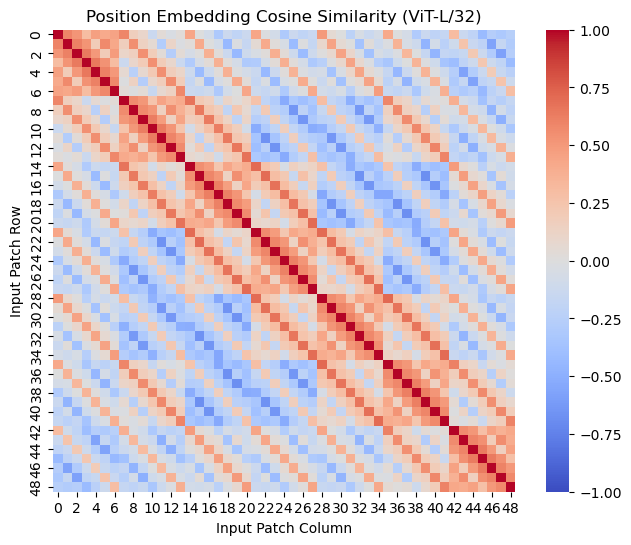

In [7]:
# Compute cosine similarity matrix
def cosine_similarity_matrix(embeddings):
    norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm  # Normalize each vector
    return np.dot(normalized_embeddings, normalized_embeddings.T)  # Cosine similarity

similarity_matrix = cosine_similarity_matrix(position_embeddings)

# Plot the cosine similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()

Sort them so that the first block is patch 1 and show the correlation matrix to the other 7 patches.

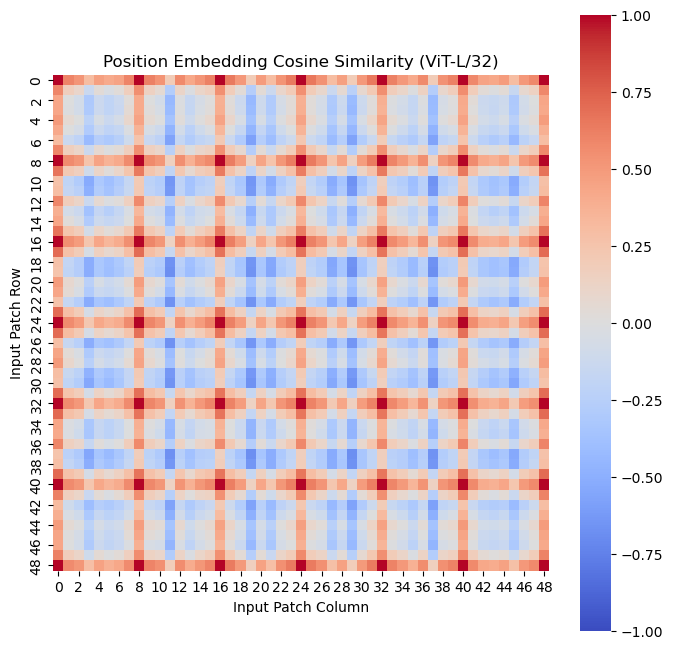

In [5]:
similarity_matrix = cosine_similarity_matrix(position_embeddings)  # Shape: (49, 49)

# Reshape into a (7,7)x(7,7) grid
grid_size = 7
similarity_matrix = similarity_matrix.reshape(grid_size, grid_size, grid_size, grid_size)
similarity_matrix = np.block([[similarity_matrix[i, j] for j in range(grid_size)] for i in range(grid_size)])

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()

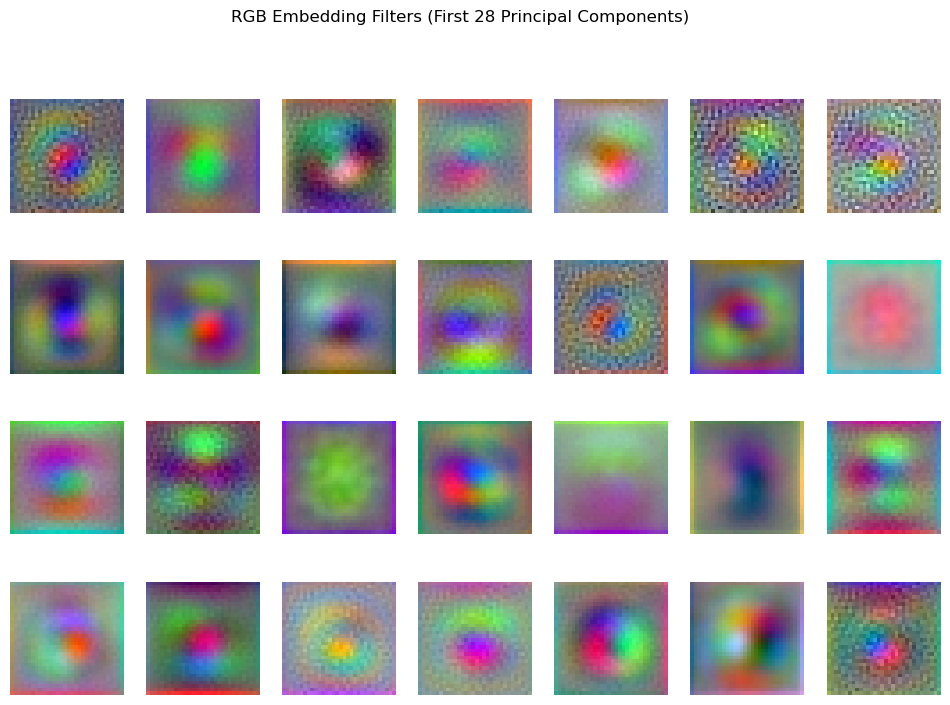

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Extract patch embedding weights
patch_embeddings = model.embeddings.patch_embeddings.projection.weight  # Shape: (1024, 3, 32, 32)
patch_embeddings = patch_embeddings.detach().cpu().numpy()  # Convert to NumPy

# Reshape to (1024, 3, 32*32) → Treat each patch as a 1024-dimensional vector per channel
num_patches, channels, patch_size, _ = patch_embeddings.shape  # (1024, 3, 32, 32)
flattened_patches = patch_embeddings.reshape(num_patches, channels, -1)  # (1024, 3, 1024)

# Apply PCA separately to each channel (reduce from 1024 → 3 principal components per channel)
pca = PCA(n_components=10)
principal_components = np.zeros((num_patches, 3, patch_size, patch_size))  # Prepare array for reconstructed images

for c in range(3):  # Loop over R, G, B channels
    transformed = pca.fit_transform(flattened_patches[:, c, :])  # Shape: (1024, 3)
    reconstructed = pca.inverse_transform(transformed)  # Back to (1024, 1024)
    principal_components[:, c, :, :] = reconstructed.reshape(num_patches, patch_size, patch_size)

# Select first 28 filters for visualization
num_filters = 28
fig, axes = plt.subplots(4, 7, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        img = principal_components[i].transpose(1, 2, 0)  # Convert (3, 32, 32) → (32, 32, 3)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] range
        ax.imshow(img)
        ax.axis("off")

plt.suptitle("RGB Embedding Filters (First 28 Principal Components)")
plt.show()